In [ ]:
import torch
import kagglehub
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from matplotlib import cm
from torch import nn, optim
from __future__ import annotations
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output

import warnings

In [ ]:
import os
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

# Create a .kaggle directory and move the file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
path = kagglehub.dataset_download("bloodlaac/products-dataset")

print("Path to dataset files:", path)

100%|██████████| 869M/869M [00:32<00:00, 28.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bloodlaac/products-dataset/versions/1


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
IMAGE_SIZE = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
food_dir = Path(f"{path}/products_dataset")

FOOD = [
    'FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry',
    'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry',
    'FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshPotato', 'FreshTomato',
    'RottenBellpepper', 'RottenCarrot', 'RottenCucumber', 'RottenPotato', 'RottenTomato'
]

In [ ]:
class LabeledDataset():
    def __init__(
        self,
        food_dir: Path,
        food_classes: list[str],
        transform=None) -> LabeledDataset:

        self.food_dir = food_dir
        self.food_classes = food_classes
        self.transform = transform
        self.images_paths = []
        self.labels = []

        for cls_name in food_classes:
            class_path = Path(food_dir)
            class_path /= cls_name

            for image_name in class_path.iterdir():
                image_path = class_path / image_name
                self.images_paths.append(image_path)
                self.labels.append(food_classes.index(cls_name))

    def __len__(self) -> int:
        return len(self.images_paths)

    def __getitem__(self, index: int):
        image = Image.open(self.images_paths[index]).convert("RGB")
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transforms = T.Compose([
    T.Resize(int(IMAGE_SIZE * 1.14)),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.3),
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    T.ToTensor(),
    T.Normalize(IMAGE_MEAN, IMAGE_STD),
])

In [ ]:
eval_transforms = T.Compose([
    T.Resize(int(IMAGE_SIZE * 1.14)),
    T.ToTensor(),
    T.Normalize(IMAGE_MEAN, IMAGE_STD),
])

In [ ]:
food_dataset = LabeledDataset(food_dir, FOOD)

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    food_dataset, [0.6, 0.2, 0.2]
)

In [ ]:
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transforms = eval_transforms
test_dataset.dataset.transforms = eval_transforms

In [ ]:
train_dataloader = DataLoader(
  train_dataset,
  batch_size=16,
  shuffle=True,
  pin_memory=True  # TODO: fix
)

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class Block(nn.Module):
    """
    Create basic unit of ResNet.

    Consists of two convolutional layers.

    """

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            downsampling=None
        ) -> Block:

        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,  # TODO: Replace with padding="same"
            padding=1
        )
        self.downsampling = downsampling

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input = x

        pred = self.bn1(self.conv1(x))
        pred = self.relu(pred)
        pred = self.bn2(self.conv2(pred))

        if self.downsampling is not None:
            input = self.downsampling(x)

        pred += input
        pred = self.relu(pred)

        return pred

In [ ]:
class ResNet(nn.Module):
    """
    Build model ResNet and return prediction

    """

    def __init__(self, blocks_num_list: list[int]) -> ResNet:
        """
        ResNet init.

        Parameters
        ----------
        blocks_num_list : list[int]
                          Number of basic blocks for each layer.

        """
        super().__init__()

        self.in_channels = 64  # Default number of channels for first layer. Mutable!

        # Reduce resolution of picture by 2
        # 224 -> 112
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3
        )
        self.batch_norm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 112 -> 56

        self.layer1 = self.create_layer(  # Default stride. No resolution reduction.
            out_channels=64,
            num_blocks=blocks_num_list[0]
        )
        self.layer2 = self.create_layer(  # Resolution reduction. 56 -> 28
            out_channels=128,
            num_blocks=blocks_num_list[1],
            stride=2
        )
        self.layer3 = self.create_layer(  # Resolution reduction. 28 -> 14
            out_channels=256,
            num_blocks=blocks_num_list[2],
            stride=2
        )
        self.layer4 = self.create_layer(  # Resolution reduction. 14 -> 7
            out_channels=512,
            num_blocks=blocks_num_list[3],
            stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 20)

    def create_layer(
            self,
            out_channels: int,
            num_blocks: int,
            stride: int = 1
        ) -> nn.Sequential:
        """
        Create ResNet layer.

        Parameters
        ----------
        out_channels : int
            Number of output channels per block
        num_blocks : int
            Number of blocks per layer
        stride : int, default=1
            Step of filter in conv layer

        """
        downsampling = None

        if stride != 1:
            downsampling = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )

        blocks: list[Block] = []

        blocks.append(Block(
            in_channels=self.in_channels,
            out_channels=out_channels,
            stride=stride,
            downsampling=downsampling
        ))

        self.in_channels = out_channels

        for _ in range(num_blocks - 1):
            blocks.append(Block(out_channels, out_channels))

        return nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pred = self.batch_norm(self.conv1(x))
        pred = self.relu(pred)
        pred = self.pooling(pred)

        pred = self.layer1(pred)
        pred = self.layer2(pred)
        pred = self.layer3(pred)
        pred = self.layer4(pred)

        pred = self.avgpool(pred)
        pred = torch.flatten(pred, 1)
        pred = self.fc(pred)

        return pred

In [ ]:
def plot_history(
        epochs: int,
        train_history: list,
        val_history: list,
        optimizer_name: str,
        label: str
    ):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
    ax1.plot(np.arange(1, epochs + 1), train_history, label=label)
    ax2.plot(np.arange(1, epochs + 1), val_history, label=label)

    for ax in (ax1, ax2):
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower right')
        ax.grid(True)

    ax1.set_title(f'{optimizer_name} Training accuracy')
    ax2.set_title(f'{optimizer_name} Validation accuracy')

    plt.tight_layout()
    plt.show()

In [ ]:
def validate(model, loader, criterion):
    correct, total = 0, 0
    val_loss = 0.0

    model.eval()

    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)

        loss = criterion(pred, labels)
        val_loss += loss.item() * len(labels)
        total += len(labels)

        pred = torch.argmax(pred, dim=1)

        correct += (pred == labels).sum().item()

    accuracy = correct / total
    loss = val_loss / total

    return accuracy, loss

In [ ]:
def train(model, criterion, train_loader, val_loader, optimizer, epochs=10):
    train_acc, train_loss = [], []
    validation_acc, validation_loss = [], []

    model.train()

    for epoch in tqdm(range(epochs), leave=False):
        correct, total = 0, 0
        epoch_loss = 0.0

        for i, batch in enumerate(train_loader, start=1):
            images, labels = batch

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels)

            loss.backward()
            optimizer.step()

            pred = torch.argmax(pred, dim=1)

            total += len(labels)
            epoch_loss += loss.item() * pred.shape[0]
            correct += (pred == labels).sum().item()
            accuracy = correct / total

            if i % 100 == 0:
              temp_loss = epoch_loss / total

              print(f"Epoch: [{epoch}/{epochs}], Step: [{i}/{len(train_loader)}]\n"
                    f"Train loss: {temp_loss:.4f}, Train Accuracy: {accuracy:.4f}\n")

        train_acc.append(accuracy)
        train_loss.append(epoch_loss / total)
        val_acc, val_loss = validate(model, val_loader, criterion)
        validation_acc.append(val_acc)
        validation_loss.append(val_loss)

        print(f"Epoch: [{epoch}/{epochs}] has passed\n"
              f"Train loss: {train_loss[-1]:.4f}, Train accuracy: {train_acc[-1]:.4f}\n"
              f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}\n")

    return train_acc, train_loss, validation_acc, validation_loss

In [ ]:
def test(model, loader, criterion):
    correct, total = 0, 0
    test_loss = 0.0

    y_true, y_pred = [], []

    model.eval()

    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)

        loss = criterion(pred, labels)
        test_loss += loss.item() * len(labels)

        pred = torch.argmax(pred, dim=1)

        y_true.append(labels.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

        total += len(labels)
        correct += (pred == labels).sum().item()

    test_accuracy = correct / total
    test_loss = test_loss / total

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)

    return test_accuracy, test_loss, cm, report

In [ ]:
blocks_num_list = [2, 2, 2, 2]

model = ResNet(blocks_num_list).to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# TODO: add plotting graphs and cycle over epochs

In [26]:
print(f"Training ResNet18 with SGD\n")

train_acc, train_loss, val_acc, val_loss = train(
    model,
    criterion,
    train_dataloader,
    val_dataloader,
    optimizer=optimizer,
    epochs=20
)

Training ResNet18 with SGD



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: [0/20], Step: [100/450]
Train loss: 2.8549, Train Accuracy: 0.1106

Epoch: [0/20], Step: [200/450]
Train loss: 2.7421, Train Accuracy: 0.1547

Epoch: [0/20], Step: [300/450]
Train loss: 2.6379, Train Accuracy: 0.1869

Epoch: [0/20], Step: [400/450]
Train loss: 2.5646, Train Accuracy: 0.2134



  5%|▌         | 1/20 [02:38<50:13, 158.61s/it]

Epoch: [0/20] has passed
Train loss: 2.5403, Train accuracy: 0.2206
Validation loss: 2.4123, Validation accuracy: 0.2858

Epoch: [1/20], Step: [100/450]
Train loss: 2.7091, Train Accuracy: 0.1744

Epoch: [1/20], Step: [200/450]
Train loss: 2.5967, Train Accuracy: 0.2122

Epoch: [1/20], Step: [300/450]
Train loss: 2.5281, Train Accuracy: 0.2323

Epoch: [1/20], Step: [400/450]
Train loss: 2.4623, Train Accuracy: 0.2525



 10%|█         | 2/20 [05:12<46:46, 155.93s/it]

Epoch: [1/20] has passed
Train loss: 2.4345, Train accuracy: 0.2589
Validation loss: 2.1154, Validation accuracy: 0.3500

Epoch: [2/20], Step: [100/450]
Train loss: 2.1214, Train Accuracy: 0.3556

Epoch: [2/20], Step: [200/450]
Train loss: 2.1249, Train Accuracy: 0.3556

Epoch: [2/20], Step: [300/450]
Train loss: 2.0681, Train Accuracy: 0.3683

Epoch: [2/20], Step: [400/450]
Train loss: 2.0610, Train Accuracy: 0.3647



 15%|█▌        | 3/20 [07:48<44:08, 155.81s/it]

Epoch: [2/20] has passed
Train loss: 2.0388, Train accuracy: 0.3715
Validation loss: 1.8249, Validation accuracy: 0.4250

Epoch: [3/20], Step: [100/450]
Train loss: 1.9003, Train Accuracy: 0.3912

Epoch: [3/20], Step: [200/450]
Train loss: 1.8645, Train Accuracy: 0.4034

Epoch: [3/20], Step: [300/450]
Train loss: 1.8500, Train Accuracy: 0.4113

Epoch: [3/20], Step: [400/450]
Train loss: 1.8327, Train Accuracy: 0.4191



 20%|██        | 4/20 [10:25<41:41, 156.37s/it]

Epoch: [3/20] has passed
Train loss: 1.8338, Train accuracy: 0.4188
Validation loss: 1.7618, Validation accuracy: 0.4492

Epoch: [4/20], Step: [100/450]
Train loss: 1.7042, Train Accuracy: 0.4537

Epoch: [4/20], Step: [200/450]
Train loss: 1.7196, Train Accuracy: 0.4541

Epoch: [4/20], Step: [300/450]
Train loss: 1.6932, Train Accuracy: 0.4608

Epoch: [4/20], Step: [400/450]
Train loss: 1.6677, Train Accuracy: 0.4703



 25%|██▌       | 5/20 [13:02<39:08, 156.54s/it]

Epoch: [4/20] has passed
Train loss: 1.6553, Train accuracy: 0.4749
Validation loss: 1.6651, Validation accuracy: 0.4721

Epoch: [5/20], Step: [100/450]
Train loss: 1.5044, Train Accuracy: 0.5337

Epoch: [5/20], Step: [200/450]
Train loss: 1.5024, Train Accuracy: 0.5294

Epoch: [5/20], Step: [300/450]
Train loss: 1.4933, Train Accuracy: 0.5288

Epoch: [5/20], Step: [400/450]
Train loss: 1.5013, Train Accuracy: 0.5292



 30%|███       | 6/20 [15:38<36:31, 156.52s/it]

Epoch: [5/20] has passed
Train loss: 1.5097, Train accuracy: 0.5261
Validation loss: 1.4790, Validation accuracy: 0.5408

Epoch: [6/20], Step: [100/450]
Train loss: 1.4020, Train Accuracy: 0.5369

Epoch: [6/20], Step: [200/450]
Train loss: 1.4238, Train Accuracy: 0.5381

Epoch: [6/20], Step: [300/450]
Train loss: 1.4127, Train Accuracy: 0.5454

Epoch: [6/20], Step: [400/450]
Train loss: 1.4004, Train Accuracy: 0.5487



 35%|███▌      | 7/20 [18:18<34:09, 157.69s/it]

Epoch: [6/20] has passed
Train loss: 1.3987, Train accuracy: 0.5487
Validation loss: 1.4362, Validation accuracy: 0.5417

Epoch: [7/20], Step: [100/450]
Train loss: 1.3381, Train Accuracy: 0.5675

Epoch: [7/20], Step: [200/450]
Train loss: 1.3244, Train Accuracy: 0.5825

Epoch: [7/20], Step: [300/450]
Train loss: 1.3291, Train Accuracy: 0.5819

Epoch: [7/20], Step: [400/450]
Train loss: 1.3260, Train Accuracy: 0.5778



 40%|████      | 8/20 [20:54<31:24, 157.02s/it]

Epoch: [7/20] has passed
Train loss: 1.3306, Train accuracy: 0.5743
Validation loss: 1.3588, Validation accuracy: 0.5696

Epoch: [8/20], Step: [100/450]
Train loss: 1.2401, Train Accuracy: 0.5994

Epoch: [8/20], Step: [200/450]
Train loss: 1.2109, Train Accuracy: 0.6150

Epoch: [8/20], Step: [300/450]
Train loss: 1.2111, Train Accuracy: 0.6090

Epoch: [8/20], Step: [400/450]
Train loss: 1.2088, Train Accuracy: 0.6094



 45%|████▌     | 9/20 [23:27<28:34, 155.88s/it]

Epoch: [8/20] has passed
Train loss: 1.2066, Train accuracy: 0.6104
Validation loss: 1.4239, Validation accuracy: 0.5500

Epoch: [9/20], Step: [100/450]
Train loss: 1.1769, Train Accuracy: 0.6350

Epoch: [9/20], Step: [200/450]
Train loss: 1.1786, Train Accuracy: 0.6231

Epoch: [9/20], Step: [300/450]
Train loss: 1.1547, Train Accuracy: 0.6296

Epoch: [9/20], Step: [400/450]
Train loss: 1.1439, Train Accuracy: 0.6322



 50%|█████     | 10/20 [26:01<25:50, 155.05s/it]

Epoch: [9/20] has passed
Train loss: 1.1444, Train accuracy: 0.6311
Validation loss: 1.2273, Validation accuracy: 0.6150

Epoch: [10/20], Step: [100/450]
Train loss: 1.0355, Train Accuracy: 0.6687

Epoch: [10/20], Step: [200/450]
Train loss: 1.0234, Train Accuracy: 0.6631

Epoch: [10/20], Step: [300/450]
Train loss: 1.0578, Train Accuracy: 0.6523

Epoch: [10/20], Step: [400/450]
Train loss: 1.0591, Train Accuracy: 0.6569



 55%|█████▌    | 11/20 [28:35<23:12, 154.76s/it]

Epoch: [10/20] has passed
Train loss: 1.0520, Train accuracy: 0.6592
Validation loss: 1.2175, Validation accuracy: 0.6208

Epoch: [11/20], Step: [100/450]
Train loss: 1.0107, Train Accuracy: 0.6681

Epoch: [11/20], Step: [200/450]
Train loss: 0.9963, Train Accuracy: 0.6747

Epoch: [11/20], Step: [300/450]
Train loss: 1.0176, Train Accuracy: 0.6719

Epoch: [11/20], Step: [400/450]
Train loss: 1.0298, Train Accuracy: 0.6694



 60%|██████    | 12/20 [31:07<20:31, 153.94s/it]

Epoch: [11/20] has passed
Train loss: 1.0272, Train accuracy: 0.6699
Validation loss: 1.0599, Validation accuracy: 0.6508

Epoch: [12/20], Step: [100/450]
Train loss: 0.9381, Train Accuracy: 0.6981

Epoch: [12/20], Step: [200/450]
Train loss: 0.9733, Train Accuracy: 0.6881

Epoch: [12/20], Step: [300/450]
Train loss: 0.9533, Train Accuracy: 0.6956

Epoch: [12/20], Step: [400/450]
Train loss: 0.9527, Train Accuracy: 0.6950



 65%|██████▌   | 13/20 [33:40<17:56, 153.82s/it]

Epoch: [12/20] has passed
Train loss: 0.9535, Train accuracy: 0.6953
Validation loss: 1.1170, Validation accuracy: 0.6450

Epoch: [13/20], Step: [100/450]
Train loss: 0.9494, Train Accuracy: 0.6825

Epoch: [13/20], Step: [200/450]
Train loss: 0.9108, Train Accuracy: 0.7013

Epoch: [13/20], Step: [300/450]
Train loss: 0.9145, Train Accuracy: 0.7037

Epoch: [13/20], Step: [400/450]
Train loss: 0.9093, Train Accuracy: 0.7078



 70%|███████   | 14/20 [36:14<15:22, 153.70s/it]

Epoch: [13/20] has passed
Train loss: 0.9104, Train accuracy: 0.7094
Validation loss: 1.1843, Validation accuracy: 0.6350

Epoch: [14/20], Step: [100/450]
Train loss: 0.9229, Train Accuracy: 0.7081

Epoch: [14/20], Step: [200/450]
Train loss: 0.8926, Train Accuracy: 0.7163

Epoch: [14/20], Step: [300/450]
Train loss: 0.8813, Train Accuracy: 0.7140

Epoch: [14/20], Step: [400/450]
Train loss: 0.8796, Train Accuracy: 0.7131



 75%|███████▌  | 15/20 [38:47<12:48, 153.66s/it]

Epoch: [14/20] has passed
Train loss: 0.8769, Train accuracy: 0.7169
Validation loss: 0.9795, Validation accuracy: 0.6867

Epoch: [15/20], Step: [100/450]
Train loss: 0.8125, Train Accuracy: 0.7550

Epoch: [15/20], Step: [200/450]
Train loss: 0.8050, Train Accuracy: 0.7491

Epoch: [15/20], Step: [300/450]
Train loss: 0.8106, Train Accuracy: 0.7446

Epoch: [15/20], Step: [400/450]
Train loss: 0.8266, Train Accuracy: 0.7392



 80%|████████  | 16/20 [41:22<10:15, 153.81s/it]

Epoch: [15/20] has passed
Train loss: 0.8291, Train accuracy: 0.7367
Validation loss: 0.9027, Validation accuracy: 0.7100

Epoch: [15/20] has passed
Train loss: 0.8291, Train accuracy: 0.7367
Validation loss: 0.9027, Validation accuracy: 0.7100

Epoch: [16/20], Step: [100/450]
Train loss: 0.7682, Train Accuracy: 0.7544

Epoch: [16/20], Step: [100/450]
Train loss: 0.7682, Train Accuracy: 0.7544

Epoch: [16/20], Step: [200/450]
Train loss: 0.7810, Train Accuracy: 0.7406

Epoch: [16/20], Step: [200/450]
Train loss: 0.7810, Train Accuracy: 0.7406

Epoch: [16/20], Step: [300/450]
Train loss: 0.8008, Train Accuracy: 0.7379

Epoch: [16/20], Step: [300/450]
Train loss: 0.8008, Train Accuracy: 0.7379

Epoch: [16/20], Step: [400/450]
Train loss: 0.7937, Train Accuracy: 0.7448

Epoch: [16/20], Step: [400/450]
Train loss: 0.7937, Train Accuracy: 0.7448



 85%|████████▌ | 17/20 [43:55<07:41, 153.70s/it]

Epoch: [16/20] has passed
Train loss: 0.7963, Train accuracy: 0.7446
Validation loss: 0.9322, Validation accuracy: 0.6950

Epoch: [16/20] has passed
Train loss: 0.7963, Train accuracy: 0.7446
Validation loss: 0.9322, Validation accuracy: 0.6950

Epoch: [17/20], Step: [100/450]
Train loss: 0.7997, Train Accuracy: 0.7481

Epoch: [17/20], Step: [100/450]
Train loss: 0.7997, Train Accuracy: 0.7481

Epoch: [17/20], Step: [200/450]
Train loss: 0.7477, Train Accuracy: 0.7584

Epoch: [17/20], Step: [200/450]
Train loss: 0.7477, Train Accuracy: 0.7584

Epoch: [17/20], Step: [300/450]
Train loss: 0.7435, Train Accuracy: 0.7602

Epoch: [17/20], Step: [300/450]
Train loss: 0.7435, Train Accuracy: 0.7602

Epoch: [17/20], Step: [400/450]
Train loss: 0.7538, Train Accuracy: 0.7561

Epoch: [17/20], Step: [400/450]
Train loss: 0.7538, Train Accuracy: 0.7561



 90%|█████████ | 18/20 [46:29<05:07, 153.90s/it]

Epoch: [17/20] has passed
Train loss: 0.7611, Train accuracy: 0.7532
Validation loss: 1.0808, Validation accuracy: 0.6587

Epoch: [17/20] has passed
Train loss: 0.7611, Train accuracy: 0.7532
Validation loss: 1.0808, Validation accuracy: 0.6587

Epoch: [18/20], Step: [100/450]
Train loss: 0.6943, Train Accuracy: 0.7756

Epoch: [18/20], Step: [100/450]
Train loss: 0.6943, Train Accuracy: 0.7756

Epoch: [18/20], Step: [200/450]
Train loss: 0.7229, Train Accuracy: 0.7656

Epoch: [18/20], Step: [200/450]
Train loss: 0.7229, Train Accuracy: 0.7656

Epoch: [18/20], Step: [300/450]
Train loss: 0.6973, Train Accuracy: 0.7731

Epoch: [18/20], Step: [300/450]
Train loss: 0.6973, Train Accuracy: 0.7731

Epoch: [18/20], Step: [400/450]
Train loss: 0.7034, Train Accuracy: 0.7720

Epoch: [18/20], Step: [400/450]
Train loss: 0.7034, Train Accuracy: 0.7720



 95%|█████████▌| 19/20 [49:04<02:34, 154.13s/it]

Epoch: [18/20] has passed
Train loss: 0.7078, Train accuracy: 0.7715
Validation loss: 0.9776, Validation accuracy: 0.7113

Epoch: [18/20] has passed
Train loss: 0.7078, Train accuracy: 0.7715
Validation loss: 0.9776, Validation accuracy: 0.7113

Epoch: [19/20], Step: [100/450]
Train loss: 0.6899, Train Accuracy: 0.7650

Epoch: [19/20], Step: [100/450]
Train loss: 0.6899, Train Accuracy: 0.7650

Epoch: [19/20], Step: [200/450]
Train loss: 0.6979, Train Accuracy: 0.7666

Epoch: [19/20], Step: [200/450]
Train loss: 0.6979, Train Accuracy: 0.7666

Epoch: [19/20], Step: [300/450]
Train loss: 0.6963, Train Accuracy: 0.7673

Epoch: [19/20], Step: [300/450]
Train loss: 0.6963, Train Accuracy: 0.7673

Epoch: [19/20], Step: [400/450]
Train loss: 0.6920, Train Accuracy: 0.7678

Epoch: [19/20], Step: [400/450]
Train loss: 0.6920, Train Accuracy: 0.7678



Epoch: [19/20] has passed
Train loss: 0.6974, Train accuracy: 0.7668
Validation loss: 0.9313, Validation accuracy: 0.7154



Epoch: [19/20] has passed
Train loss: 0.6974, Train accuracy: 0.7668
Validation loss: 0.9313, Validation accuracy: 0.7154



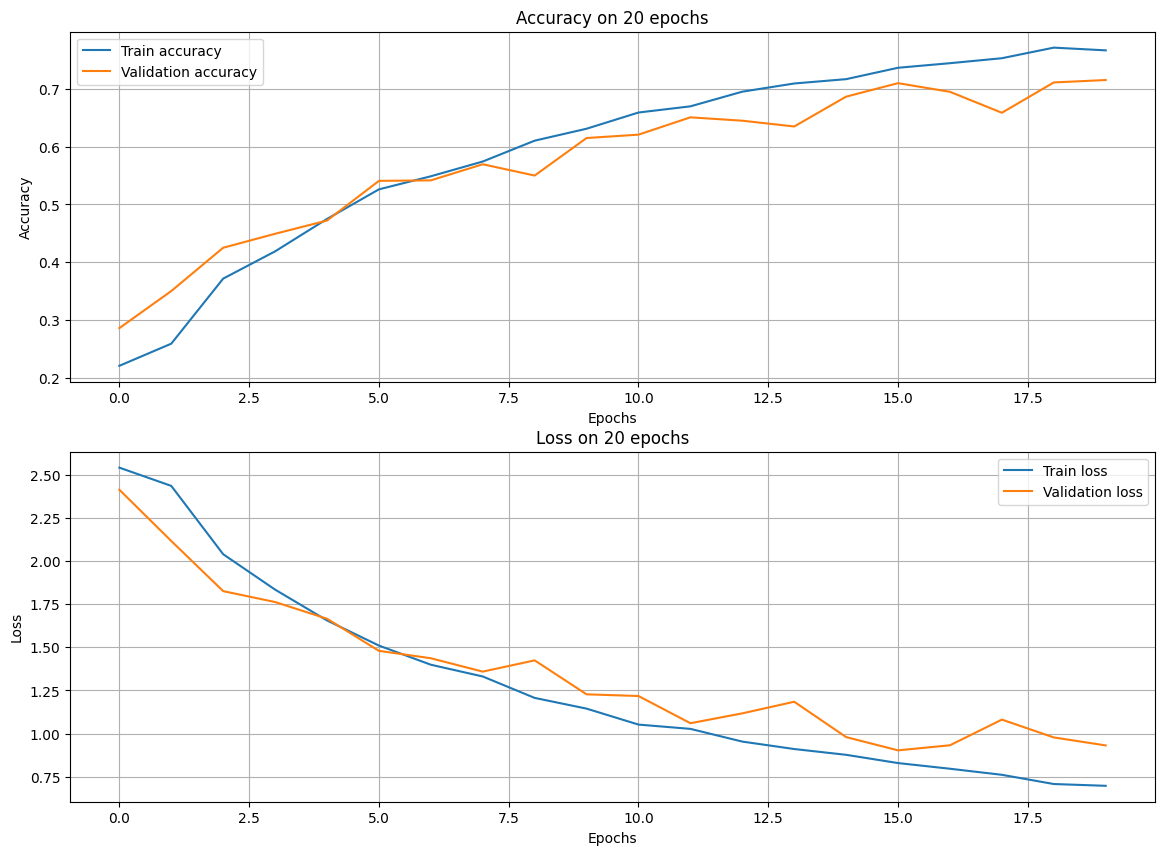

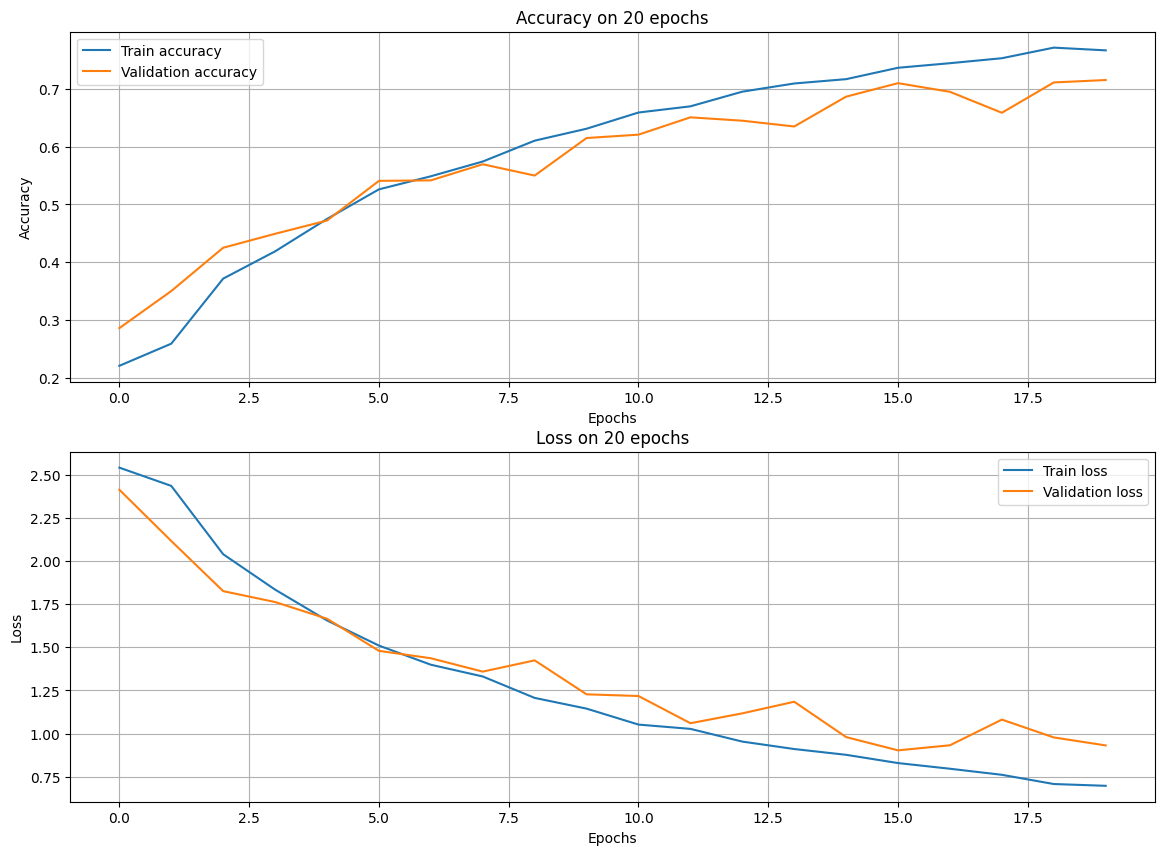

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(np.arange(20), train_acc, label="Train accuracy")
ax1.plot(np.arange(20), val_acc, label="Validation accuracy")
ax2.plot(np.arange(20), train_loss, label="Train loss")
ax2.plot(np.arange(20), val_loss, label="Validation loss")

ax1.set_title("Accuracy on 20 epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

ax2.set_title("Loss on 20 epochs")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.show()

In [28]:
test_acc, test_loss, cm, report = test(model, test_dataloader, criterion)

print(f"\nTest accuracy: {test_acc:.4f}")
print(f"\nTest loss: {test_loss:.4f}")
print(f"\nReport:\n{report}")


Test accuracy: 0.7317

Test loss: 0.9112

Report:
              precision    recall  f1-score   support

           0     0.7955    0.8537    0.8235       123
           1     0.7083    0.8293    0.7640       123
           2     0.7917    0.8190    0.8051       116
           3     0.7351    0.8952    0.8073       124
           4     0.9700    0.7823    0.8661       124
           5     0.6667    0.5577    0.6073       104
           6     0.8571    0.7727    0.8127       132
           7     0.9111    0.7321    0.8119       112
           8     0.9123    0.5149    0.6582       101
           9     0.8962    0.8333    0.8636       114
          10     0.8455    0.7209    0.7782       129
          11     0.5476    0.8846    0.6765       130
          12     0.8268    0.7895    0.8077       133
          13     0.8842    0.7500    0.8116       112
          14     0.7851    0.8636    0.8225       110
          15     0.4769    0.5487    0.5103       113
          16     0.4000    0.4

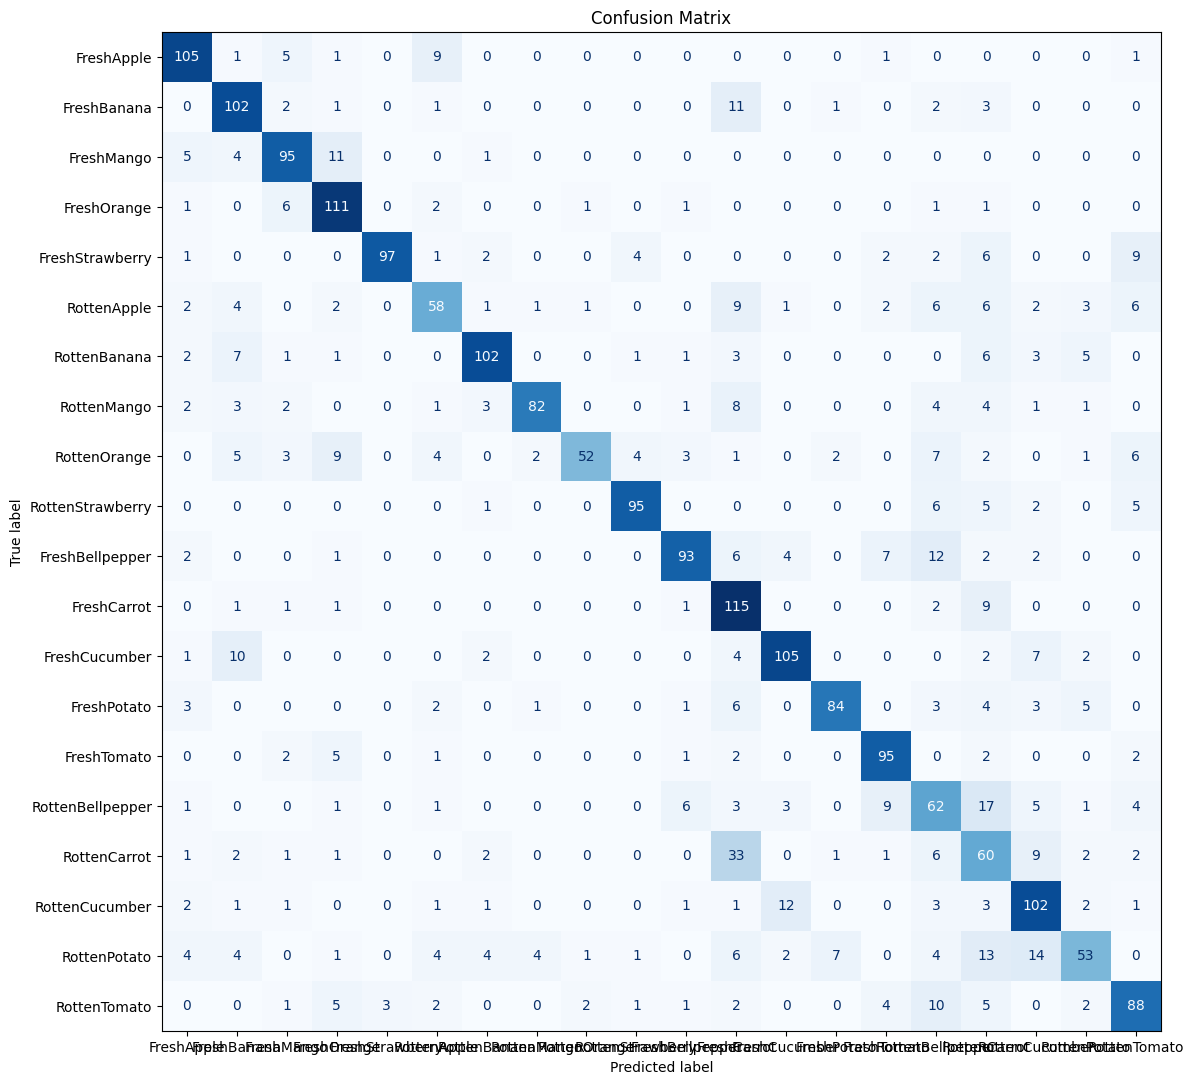

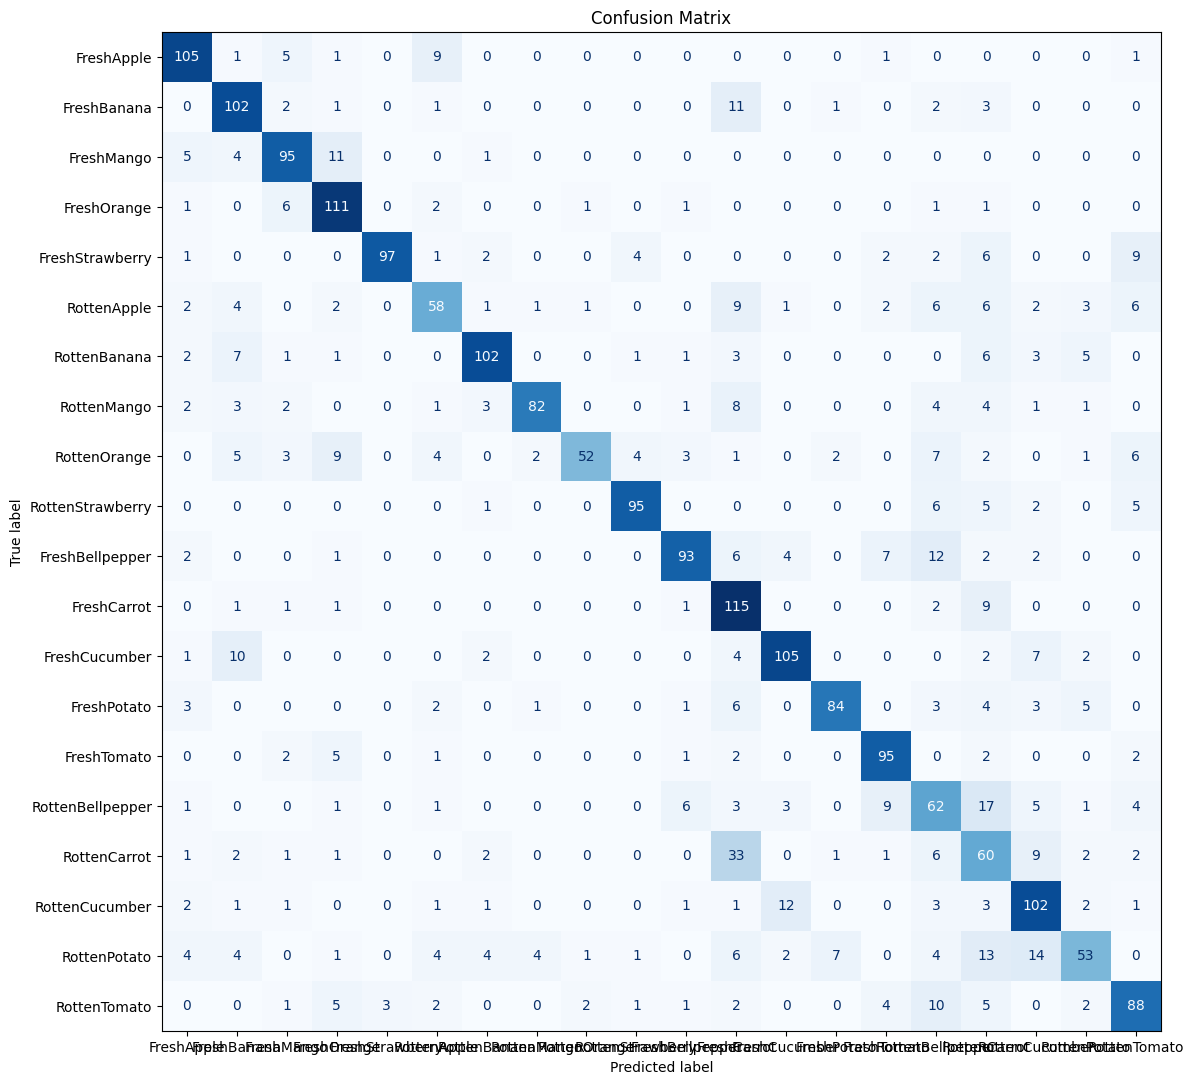

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=FOOD)
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title("Confusion Matrix")

plt.tight_layout()
plt.show()